# Import statements 

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
from  my_ml_lib import MetricTools, PlotTools

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure 
import json
import datetime
import copy
from PIL import Image as im
import joblib
from sklearn.model_selection import train_test_split
# import math as Math
import random
import torch.optim

In [5]:
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torchvision

In [6]:
import cv2

# Saving and Loading code 

In [7]:
# Saving and Loading models using joblib 
def save(filename, obj):
  with open(filename, 'wb') as handle:
      joblib.dump(obj, handle, protocol=pickle.HIGHEST_PROTOCOL)

def load(filename):
  with open(filename, 'rb') as handle:
      return joblib.load(filename)


# Importing Dataset 

In [8]:
p = "/content/drive/MyDrive/A3/"
data_path = p + "dataset/train.pkl"
x = load(data_path)

In [9]:
# save_path = "/content/drive/MyDrive/SEM-2/05-DL /Assignments/A3/dataset/"
# # saving the images and labels array 
# save(save_path + "data_image.pkl",data_image)
# save(save_path + "data_label.pkl",data_label)
# # dict values where labels key and image arrays as vlaues in form of list 
# save(save_path + "my_dict.pkl",my_dict)

In [10]:
save_path = p + "dataset/"
# saving the images and labels array 
data_image = load(save_path + "data_image.pkl")
data_label = load(save_path + "data_label.pkl")
# dict values where labels key and image arrays as vlaues in form of list 
my_dict = load(save_path + "my_dict.pkl")

In [11]:
len(data_image) , len(data_label), my_dict.keys()

(5000, 5000, dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]))

# Data Class and Data Loaders and Data transforms 

In [12]:
len(x['names']) ,x['names'][4999] , data_image[0].shape

(5000, 'train05000', (32, 32, 3))

## Splitting the data into train and val

In [13]:
X_train, X_test, y_train, y_test = train_test_split(data_image, data_label, test_size=0.10, random_state=42,stratify=data_label )

In [14]:
len(X_train) , len(y_train) , len(X_test) ,len(y_test)

(4500, 4500, 500, 500)

In [15]:
pd.DataFrame(y_test).value_counts() 

9    50
8    50
7    50
6    50
5    50
4    50
3    50
2    50
1    50
0    50
dtype: int64

## Data Class

In [16]:
train_transforms = transforms.Compose([
                                       transforms.RandomHorizontalFlip(),
])

val_transforms = transforms.Compose([
])

In [17]:
class myDataClass(Dataset):
  """Custom dataset class"""

  def __init__(self, images, labels , transform=None):

    """
    Args:
        images : Array of all the images 
        labels : Correspoing labels of all the images 
    """
    
    self.images = images
    self.labels = labels
    self.transform = transform
    
  def __len__(self):

    return len(self.images)

  def __getitem__(self, idx):
    # converts image value between 0 and 1 and returns a tensor C,H,W 
    img = torchvision.transforms.functional.to_tensor(self.images[idx])
    target = self.labels[idx]
    

    if self.transform:
        img = self.transform(img)
    return img,target 

## Data Loaders 

In [18]:
batch = 64
train_dataset = myDataClass(X_train, y_train,train_transforms)
test_dataset = myDataClass(X_test, y_test)

train_dataloader = DataLoader(train_dataset, batch_size= batch, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size= batch, shuffle=True)

In [19]:
# next(iter(train_dataloader))[0].shape

In [20]:
len(train_dataloader) , len(test_dataloader)

(71, 8)

# Train and Test functions 

In [21]:
def load_best(all_models,model_test):
  FILE  = all_models[-1]
  
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model_test.parameters(), lr=0)

  checkpoint = torch.load(FILE)
  model_test.load_state_dict(checkpoint['model_state'])
  optimizer.load_state_dict(checkpoint['optim_state'])
  epoch = checkpoint['epoch']
  model_test.eval()

  return model_test


In [22]:
def train(save_path,epochs,train_dataloader,model,test_dataloader,optimizer,criterion,basic_name):
  model_no = 1
  c = 1
  all_models = []

  valid_loss_min = np.Inf 
  train_losses = []
  val_losses = []

  for e in range(epochs):

      train_loss = 0.0
      valid_loss = 0.0

      model.train()
      
      for idx, (images,labels) in enumerate(train_dataloader):
        
          images, labels = images.to(device) , labels.to(device) 
    
          optimizer.zero_grad()        
          log_ps= model(images)
          loss = criterion(log_ps, labels)
          loss.backward()
          optimizer.step()
          
          train_loss += ((1 / (idx + 1)) * (loss.data - train_loss))
      else:

          accuracy = 0
          correct = 0
          model.eval()

          with torch.no_grad():
              for idx, (images,labels) in enumerate(test_dataloader):

                  images, labels = images.to(device) , labels.to(device)

                  log_ps = model(images)
                  
                  _, predicted = torch.max(log_ps.data, 1)
                  loss = criterion(log_ps, labels)

                  # correct += (predicted == labels).sum().item()
                  equals = predicted == labels.view(*predicted.shape)
                  accuracy += torch.mean(equals.type(torch.FloatTensor))
                  valid_loss += ((1 / (idx + 1)) * (loss.data - valid_loss))

          print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
              e+1, 
              train_loss,
              valid_loss
              ), "Test Accuracy: {:.3f}".format(accuracy/len(test_dataloader)))

          train_losses.append(train_loss)
          val_losses.append(valid_loss)

          if valid_loss < valid_loss_min:
            
            print('Saving model..' + str(model_no))
            valid_loss_min = valid_loss

            checkpoint = {
            "epoch": e+1,
            "model_state": model.state_dict(),
            "optim_state": optimizer.state_dict(),
            "train_losses": train_losses,
            "test_losses": val_losses,
            }

            FILE =  save_path + basic_name +"_epoch_" + str(e+1) + "_model_" +  str(model_no)
            all_models.append(FILE)
            torch.save(checkpoint, FILE)
            model_no = model_no + 1
          
  
  save(save_path + basic_name + "_all_models.pkl", all_models)
  return model, train_losses, val_losses, all_models 
   

In [23]:
def plot(train_losses,val_losses,title='Training Validation Loss with CNN'):
  plt.plot(train_losses, label='Training loss')
  plt.plot(val_losses, label='Validation loss')
  plt.xlabel('Iterations')
  plt.ylabel('Loss')
  plt.legend()
  _ = plt.ylim()
  plt.title(title)
  # plt.savefig('plots/Training Validation Loss with CNN from scratch.png')
  plt.show()

In [24]:
def test(loader, model, criterion, device, name):
    test_loss = 0.
    correct = 0.
    total = 0.
    y = None
    y_hat = None
    
    model.eval()
    for batch_idx, (images, labels) in enumerate(loader):

        # move to GPU or CPU
        images, labels = images.to(device)   , labels.to(device) 
        target = labels

        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(images)
        # calculate the loss
        loss = criterion(output,labels)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]

        if y is None:
            y = target.cpu().numpy()
            y_hat = pred.data.cpu().view_as(target).numpy()
        else:
            y = np.append(y, target.cpu().numpy())
            y_hat = np.append(y_hat, pred.data.cpu().view_as(target).numpy())


        correct += np.sum(pred.view_as(labels).cpu().numpy() == labels.cpu().numpy())
        total = total + images.size(0)
        # if batch_idx % 20 == 0:
        #     print("done till batch" , batch_idx+1)
            
    print(name + ' Loss: {:.6f}\n'.format(test_loss))

    print(name + ' Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))
    return y, y_hat

In [25]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [26]:
# def train(save_path,epochs,train_dataloader,model,test_dataloader,optimizer,criterion,basic_name)
# def plot(train_losses,val_losses,title='Training Validation Loss with CNN')
# def test(loader, model, criterion, device)

# Relu [ X=2 Y=3 Z=1 ] 

## CNN-Block-123

### model 

In [27]:
cfg3 = {
    'B123': [16,16,'M','D',32,32,32,'M','D',64,'M','D'],
}

In [28]:
def make_layers3(cfg, batch_norm=True):

    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.AvgPool2d(kernel_size=2, stride=2)]
        elif v == 'M1':
            layers += [nn.AvgPool2d(kernel_size=4, stride=3)]
        elif v == 'D':
            layers += [nn.Dropout(p=0.5)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v

    return nn.Sequential(*layers)

In [29]:
class Model_B123(nn.Module):
    '''
        Model
    '''
    def __init__(self, features):

        super(Model_B123, self).__init__()
        self.features = features 

        self.classifier = nn.Sequential(
            # nn.Linear(1600, 512),
            # nn.ReLU(True),
            # nn.Linear(512, 256),
            # nn.ReLU(True),
            # nn.Linear(256, 64),
            # nn.ReLU(True),
            nn.Linear(64, 10),
        )
       
    def forward(self, x):
        x = self.features(x)
        # print(x.shape)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [30]:
# m = Model_B123(make_layers3(cfg3['B123']))
# for i,l in train_dataloader:
#   o = m(i)

In [31]:
model3 = Model_B123(make_layers3(cfg3['B123'])).to(device) 
learning_rate = 0.001
criterion3 = nn.CrossEntropyLoss()
optimizer3 = optim.Adam(model3.parameters(), lr=learning_rate)
print(model3)

Model_B123(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (7): Dropout(p=0.5, inplace=False)
    (8): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (9): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (12): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (15): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (16): R

### train 

In [35]:
# !rm  '/content/drive/MyDrive/SEM-2/05-DL /Assignments/A3/models_saved_Q1/1_3/bw_blocks/Dropout(0.5)/cnn_block123/'*
# !ls  '/content/drive/MyDrive/SEM-2/05-DL /Assignments/A3/models_saved_Q1/1_3/bw_blocks/Dropout(0.5)/cnn_block123/'

In [36]:
save_path3 = "/content/drive/MyDrive/A3/models_saved_Q1/1_5/models/"

In [37]:
m, train_losses, val_losses,m_all_models = train(save_path3,100,train_dataloader,model3,test_dataloader,optimizer3,criterion3,"cnn_b123_x2_y3_z1_with_BN_avg_pool_dp_without_WD_0.001_with_aug_epoch_100_Best")

Epoch: 1 	Training Loss: 1.964782 	Validation Loss: 1.633939 Test Accuracy: 0.430
Saving model..1
Epoch: 2 	Training Loss: 1.647395 	Validation Loss: 1.507088 Test Accuracy: 0.457
Saving model..2
Epoch: 3 	Training Loss: 1.485814 	Validation Loss: 1.387516 Test Accuracy: 0.533
Saving model..3
Epoch: 4 	Training Loss: 1.398100 	Validation Loss: 1.367716 Test Accuracy: 0.495
Saving model..4
Epoch: 5 	Training Loss: 1.273662 	Validation Loss: 1.569803 Test Accuracy: 0.439
Epoch: 6 	Training Loss: 1.233680 	Validation Loss: 1.648337 Test Accuracy: 0.461
Epoch: 7 	Training Loss: 1.199510 	Validation Loss: 1.154102 Test Accuracy: 0.576
Saving model..5
Epoch: 8 	Training Loss: 1.144552 	Validation Loss: 1.164001 Test Accuracy: 0.593
Epoch: 9 	Training Loss: 1.118600 	Validation Loss: 0.998947 Test Accuracy: 0.639
Saving model..6
Epoch: 10 	Training Loss: 1.069897 	Validation Loss: 1.318365 Test Accuracy: 0.556
Epoch: 11 	Training Loss: 1.060799 	Validation Loss: 1.079013 Test Accuracy: 0.606


### Tests and Plots 

In [46]:
# !ls "/content/drive/MyDrive/A3/models_saved_Q1/1_5/models/"

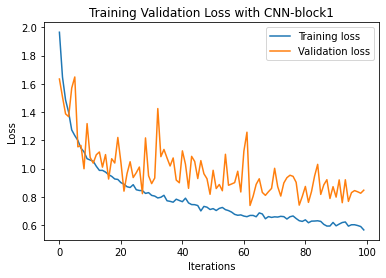

In [38]:
plot(train_losses,val_losses,'Training Validation Loss with CNN-block1')

In [47]:
all_models3 = load(save_path3 + "cnn_b123_x2_y3_z1_with_BN_avg_pool_dp_without_WD_0.001_with_aug_epoch_100_Best_all_models.pkl")
FILE  = all_models3[-1]
m3 = Model_B123(make_layers3(cfg3['B123'])).to(device) 

In [48]:
m3 = load_best(all_models3,m3)

In [49]:
train_y, train_y_hat = test(train_dataloader, m3, criterion3, device, "TRAIN")

TRAIN Loss: 0.519609

TRAIN Accuracy: 81% (3665/4500)


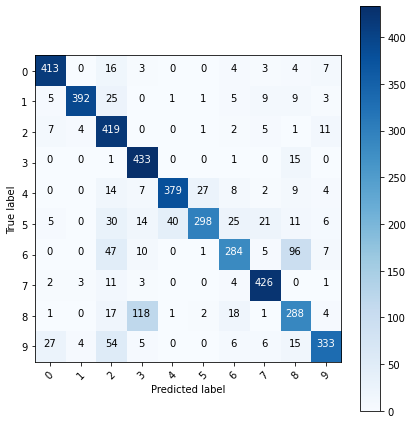

In [50]:
cm = MetricTools.confusion_matrix(train_y, train_y_hat, nclasses=10)
PlotTools.confusion_matrix(cm, [i for i in range(10)], title='',
                           filename='Confusion Matrix with CNN', figsize=(6,6))

In [51]:
test_y, test_y_hat = test(test_dataloader, m3, criterion3, device,"TEST")

TEST Loss: 0.744911

TEST Accuracy: 75% (376/500)


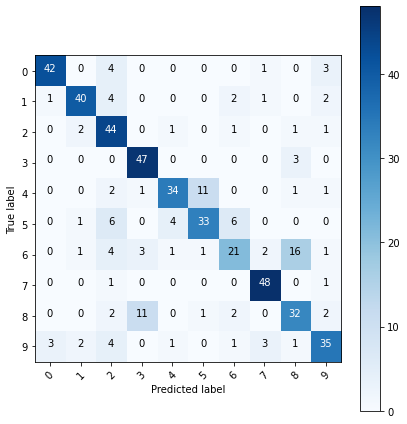

In [52]:
cm = MetricTools.confusion_matrix(test_y, test_y_hat, nclasses=10)
PlotTools.confusion_matrix(cm, [i for i in range(10)], title='',
                           filename='Confusion Matrix with CNN', figsize=(6,6))

# Visualization 

In [53]:
model_weights = [] # we will save the conv layer weights in this list
conv_layers = [] # we will save the 49 conv layers in this list
# get all the model children as list
model_children = list(m3.children())

In [54]:
model_children

[Sequential(
   (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
   (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (2): ReLU(inplace=True)
   (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
   (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (5): ReLU(inplace=True)
   (6): AvgPool2d(kernel_size=2, stride=2, padding=0)
   (7): Dropout(p=0.5, inplace=False)
   (8): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
   (9): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (10): ReLU(inplace=True)
   (11): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
   (12): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (13): ReLU(inplace=True)
   (14): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
   (15): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (16): ReLU(inplace=True)
   (17): AvgPool2d(kerne

In [78]:
# Storing all conv layers 
all_conv_layers = []
count = 0
for layer in model_children:
  if type(layer) == nn.Sequential:
    print("------")
    for inner_layer in layer.children():
      # print(type(inner_layer)== nn.Conv2d)
      if type(inner_layer)== nn.Conv2d:
        count += 1
        print(inner_layer)
        # model_weights.append(inner_layer.weight)
        all_conv_layers.append(inner_layer)

------
Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
------


In [55]:
# According to X,Y,Z = 2,3,1 ==> layer weights and layers to save are 2,5,6 - block1 block2 block3 
count = 0
for layer in model_children:
  if type(layer) == nn.Sequential:
    print("------")
    for inner_layer in layer.children():
      # print(type(inner_layer)== nn.Conv2d)
      if type(inner_layer)== nn.Conv2d:
        count += 1
        if count == 2 or count == 5 or count == 6:
          print(inner_layer)
          model_weights.append(inner_layer.weight)
          conv_layers.append(inner_layer)
      

------
Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
------


In [56]:
# take a look at the conv layers and the respective weights
for weight, conv in zip(model_weights, conv_layers):
    # print(f"WEIGHT: {weight} \nSHAPE: {weight.shape}")
    print(f"CONV: {conv} ====> SHAPE: {weight.shape}")

CONV: Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1)) ====> SHAPE: torch.Size([16, 16, 3, 3])
CONV: Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1)) ====> SHAPE: torch.Size([32, 32, 3, 3])
CONV: Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1)) ====> SHAPE: torch.Size([64, 32, 3, 3])


## Visualising the filters conv after each block 

 BLOCK-1 FILTERS


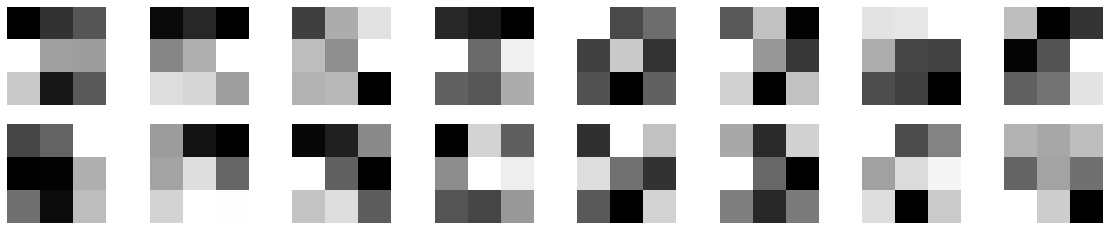

In [66]:
# visualize the first conv layer filters

print(" BLOCK-1 FILTERS")
plt.figure(figsize=(20, 17))
for i, filter in enumerate(model_weights[0]):
    plt.subplot(8, 8, i+1) # (8, 8) because in conv0 we have 7x7 filters and total of 64 (see printed shapes)
    plt.imshow(filter[0, :, :].detach().cpu(), cmap='gray')
    plt.axis('off')
    # plt.savefig('../outputs/filter.png')
plt.show()

 BLOCK-2 FILTERS


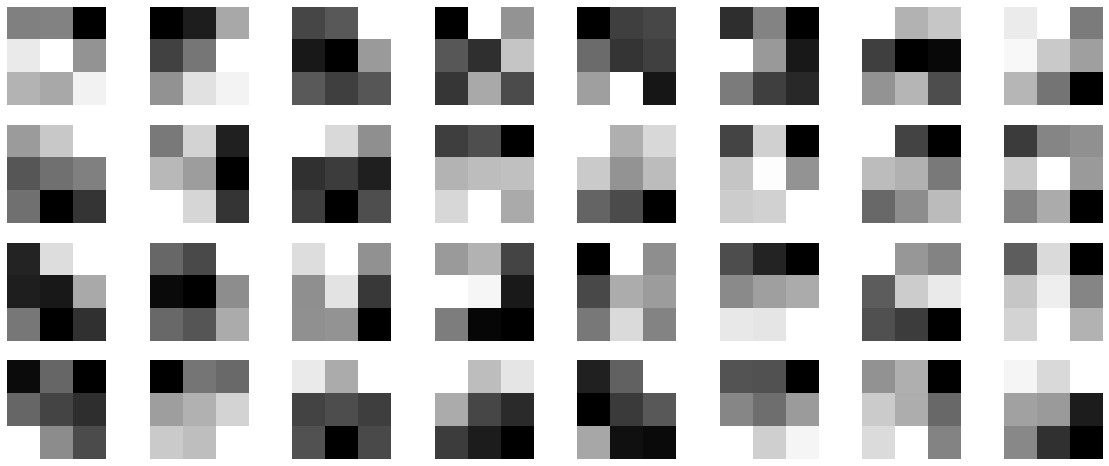

In [67]:
# visualize the first conv layer filters

print(" BLOCK-2 FILTERS")
plt.figure(figsize=(20, 17))
for i, filter in enumerate(model_weights[1]):
    plt.subplot(8, 8, i+1) # (8, 8) because in conv0 we have 7x7 filters and total of 64 (see printed shapes)
    plt.imshow(filter[0, :, :].detach().cpu(), cmap='gray')
    plt.axis('off')
    # plt.savefig('../outputs/filter.png')
plt.show()

 BLOCK-3 FILTERS


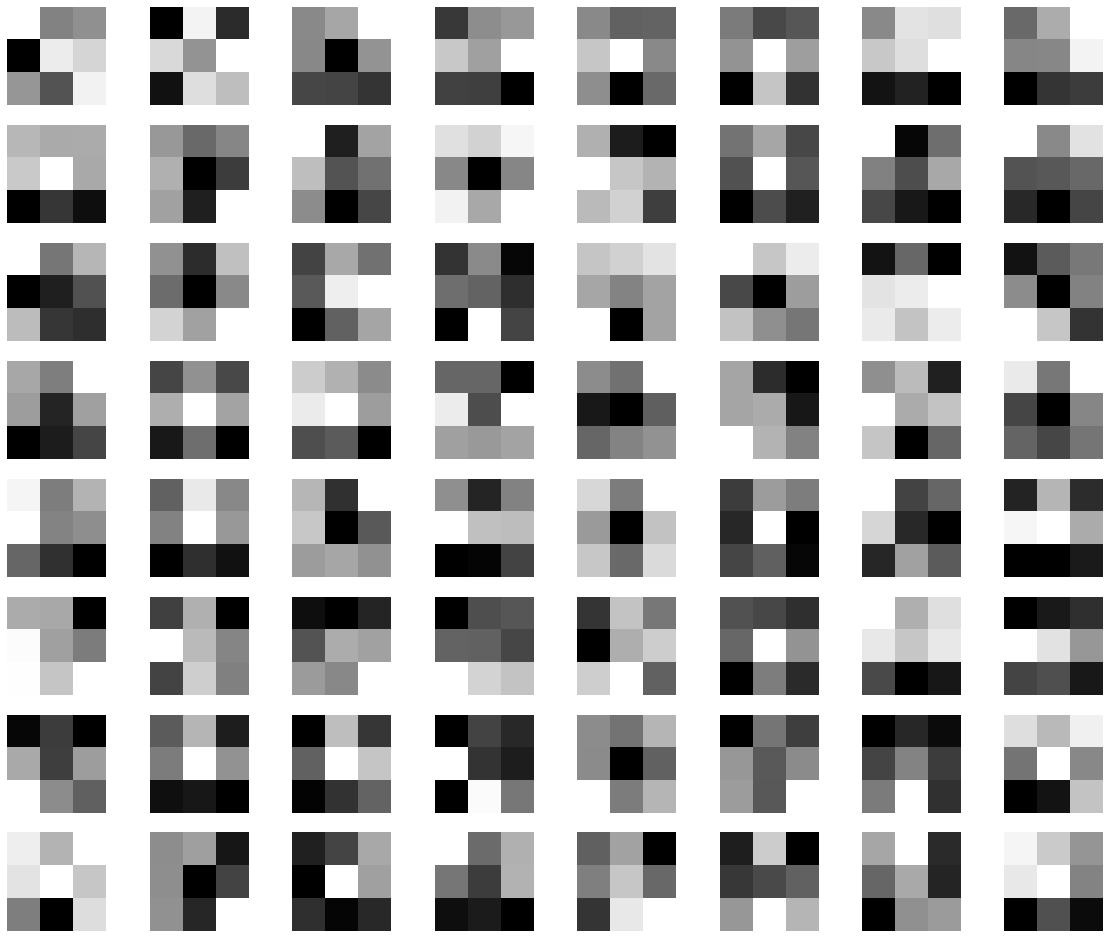

In [68]:
# visualize the first conv layer filters
print(" BLOCK-3 FILTERS")
plt.figure(figsize=(20, 17))
for i, filter in enumerate(model_weights[2]):
    plt.subplot(8, 8, i+1) # (8, 8) because in conv0 we have 7x7 filters and total of 64 (see printed shapes)
    plt.imshow(filter[0, :, :].detach().cpu(), cmap='gray')
    plt.axis('off')
    # plt.savefig('../outputs/filter.png')
plt.show()

## Visualising feature maps 

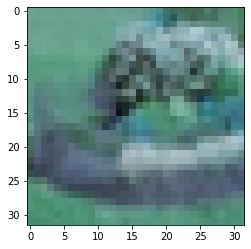

In [83]:
import cv2 as cv
# Image 
# read and visualize an image
img = cv.cvtColor(X_train[1000], cv.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

# define the transforms
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
])


In [84]:
img = np.array(img)
# apply the transforms
img = transform(img)
print(img.size())
# unsqueeze to add a batch dimension
img = img.unsqueeze(0)
print(img.size())
img.to(device)

torch.Size([3, 32, 32])
torch.Size([1, 3, 32, 32])


tensor([[[[0.4235, 0.4157, 0.4196,  ..., 0.3255, 0.3216, 0.2824],
          [0.4235, 0.4157, 0.4196,  ..., 0.3412, 0.3216, 0.2902],
          [0.4039, 0.4039, 0.4118,  ..., 0.3608, 0.3529, 0.3216],
          ...,
          [0.3255, 0.3020, 0.3020,  ..., 0.2980, 0.3137, 0.3137],
          [0.2941, 0.3020, 0.3176,  ..., 0.2941, 0.2863, 0.2980],
          [0.2824, 0.2784, 0.2902,  ..., 0.2902, 0.3020, 0.3059]],

         [[0.6353, 0.6235, 0.6314,  ..., 0.5137, 0.5333, 0.4980],
          [0.6392, 0.6275, 0.6353,  ..., 0.5412, 0.5373, 0.4941],
          [0.6196, 0.6118, 0.6235,  ..., 0.5451, 0.5529, 0.5137],
          ...,
          [0.5765, 0.5608, 0.5647,  ..., 0.5255, 0.5569, 0.5647],
          [0.5608, 0.5647, 0.5804,  ..., 0.5529, 0.5412, 0.5569],
          [0.5451, 0.5373, 0.5529,  ..., 0.5451, 0.5569, 0.5647]],

         [[0.5686, 0.5608, 0.5647,  ..., 0.4431, 0.4392, 0.3804],
          [0.5725, 0.5608, 0.5686,  ..., 0.4549, 0.4431, 0.3961],
          [0.5529, 0.5451, 0.5569,  ..., 0

In [88]:
  # pass the image through all the layers
  results = [all_conv_layers[0](img.to(device))]
  for i in range(1, len(all_conv_layers)):
      # pass the result from the last layer to the next layer
      results.append(all_conv_layers[i](results[-1]).to(device))
  # make a copy of the `results`
  outputs = results

torch.Size([16, 28, 28])
Saving layer 1 feature maps...


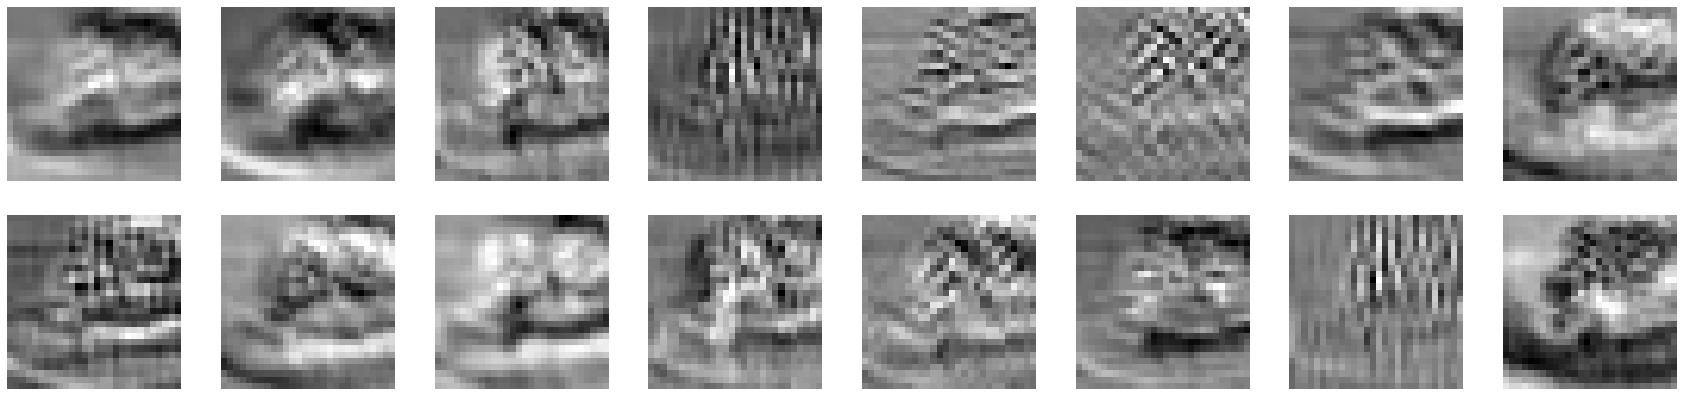

torch.Size([32, 22, 22])
Saving layer 4 feature maps...


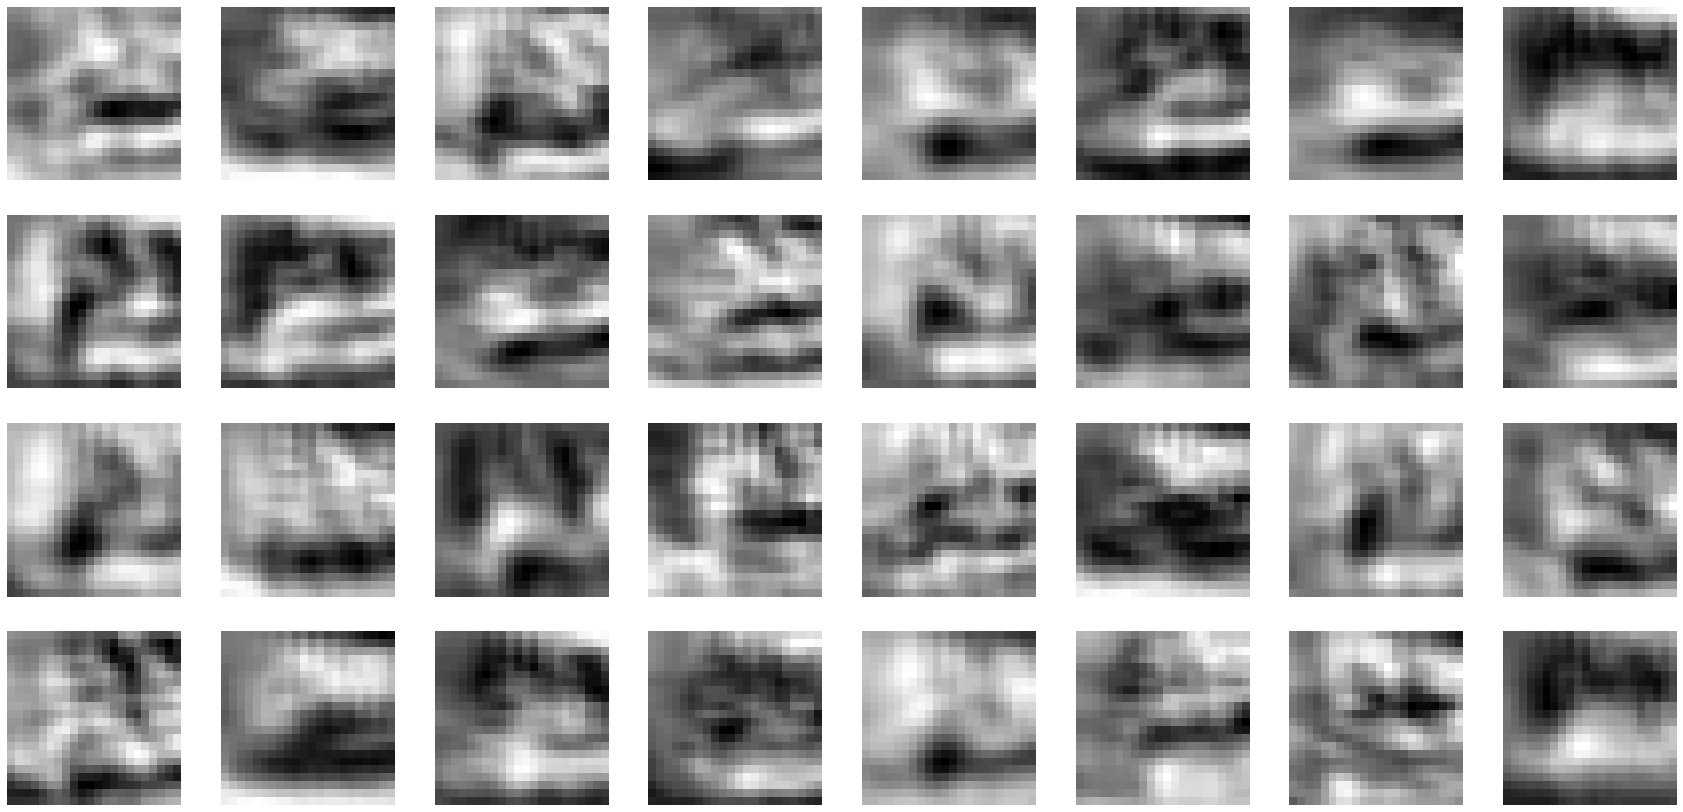

torch.Size([64, 20, 20])
Saving layer 5 feature maps...


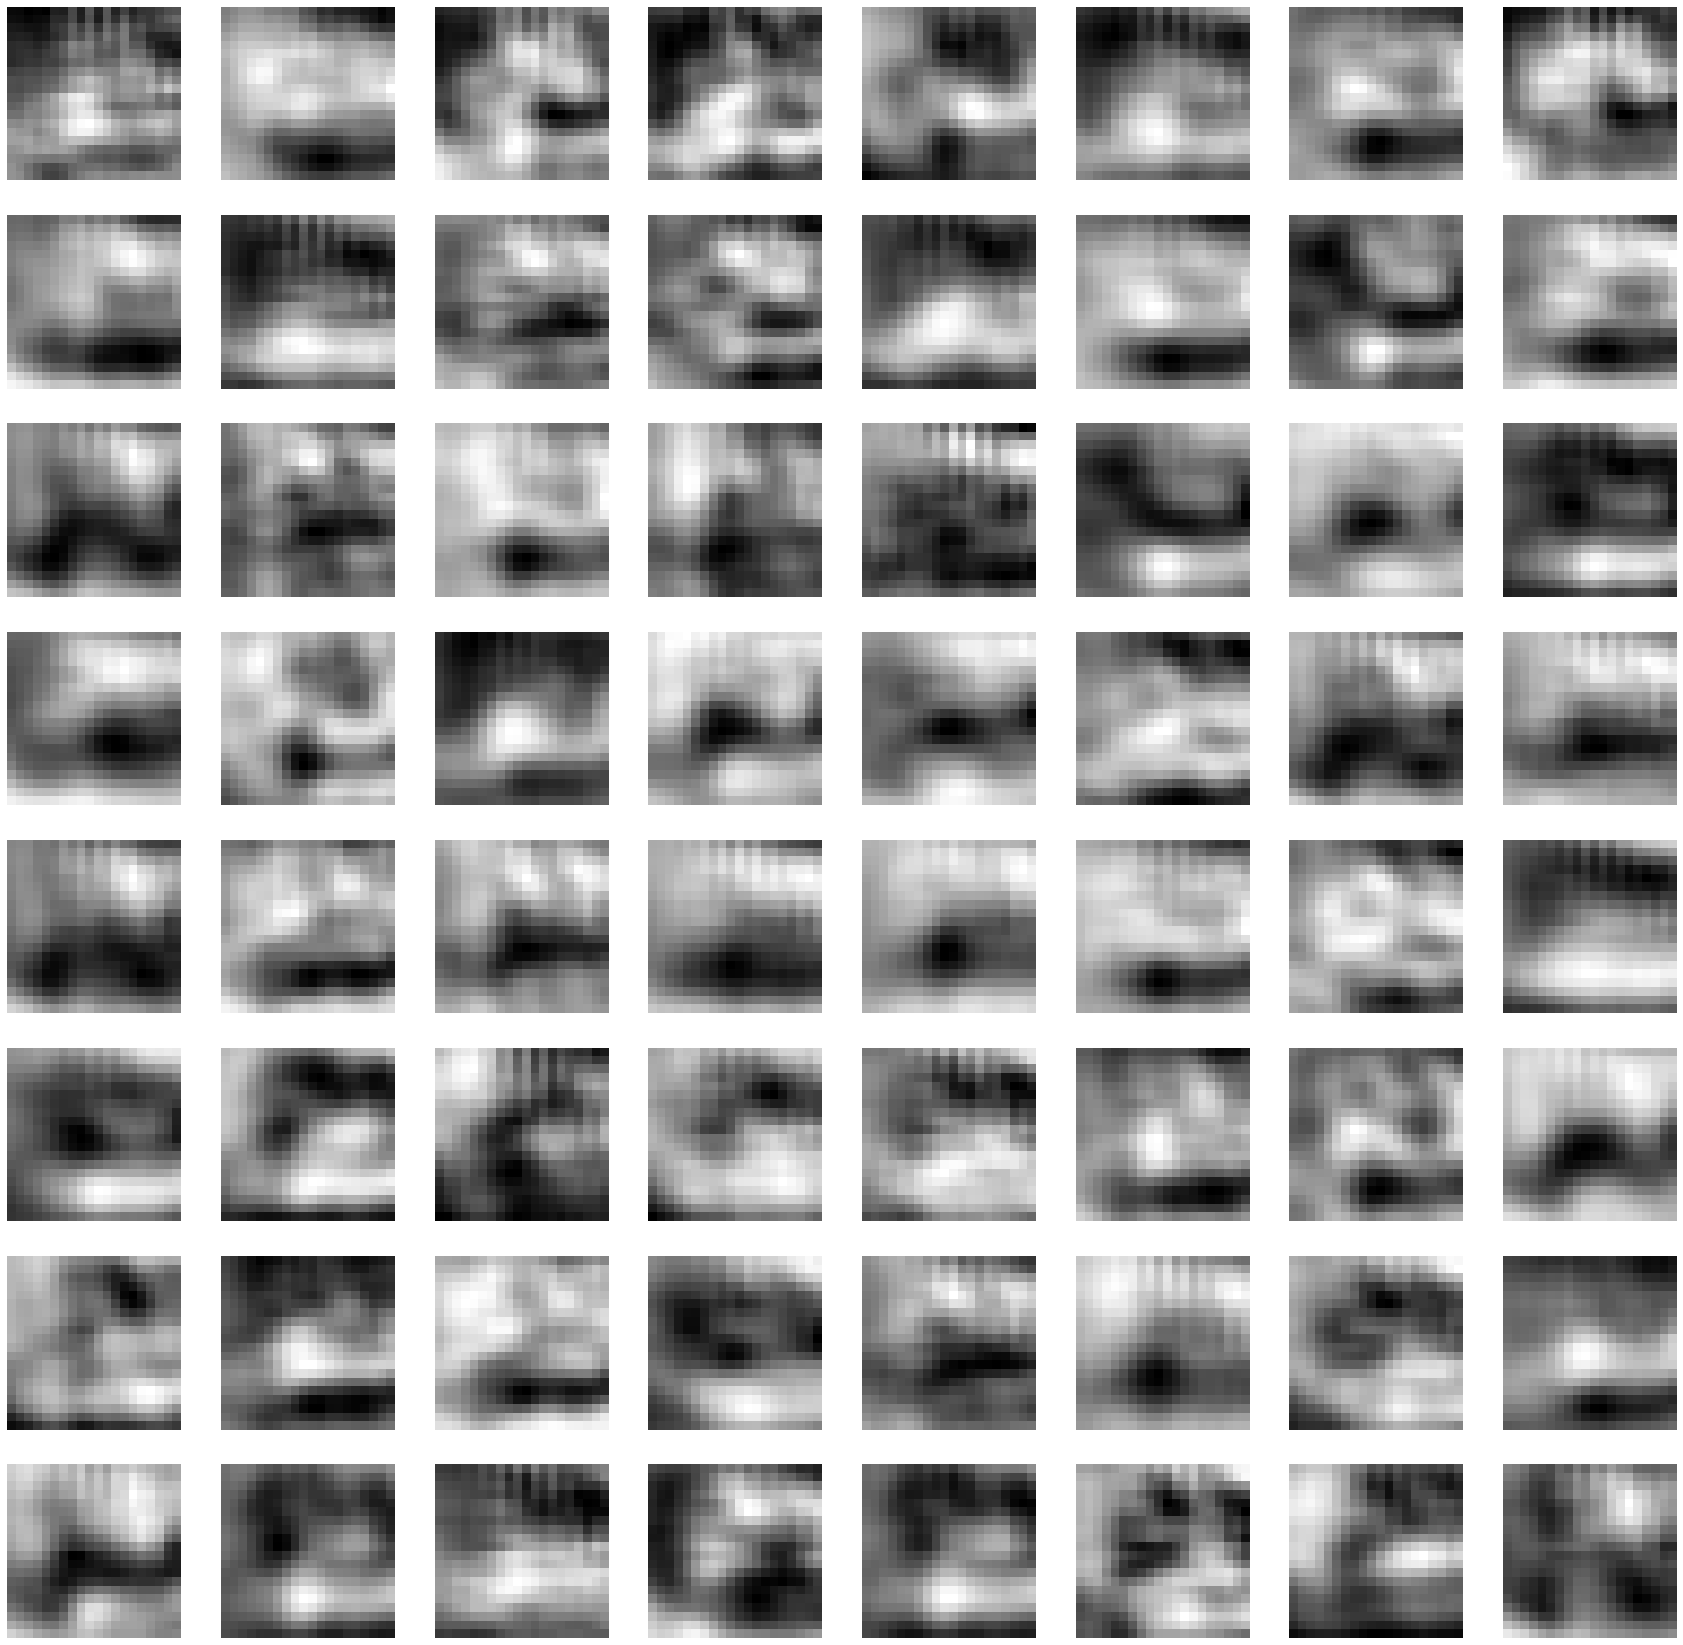

In [94]:
# visualize 64 features from each layer 
# (although there are more feature maps in the upper layers)
for num_layer in range(len(outputs)):
    if num_layer == 1 or num_layer == 4 or num_layer == 5:
      plt.figure(figsize=(30, 30))
      layer_viz = outputs[num_layer][0, :, :, :]
      layer_viz = layer_viz.data
      print(layer_viz.size())
      for i, filter in enumerate(layer_viz):
          if i == 64: # we will visualize only 8x8 blocks from each layer
              break
          plt.subplot(8, 8, i + 1)
          plt.imshow(filter.cpu(), cmap='gray')
          plt.axis("off")
      print(f"Saving layer {num_layer} feature maps...")
      # plt.savefig(f"../outputs/layer_{num_layer}.png")
      plt.show()
      plt.close()

torch.Size([16, 30, 30])
Saving layer 0 feature maps...


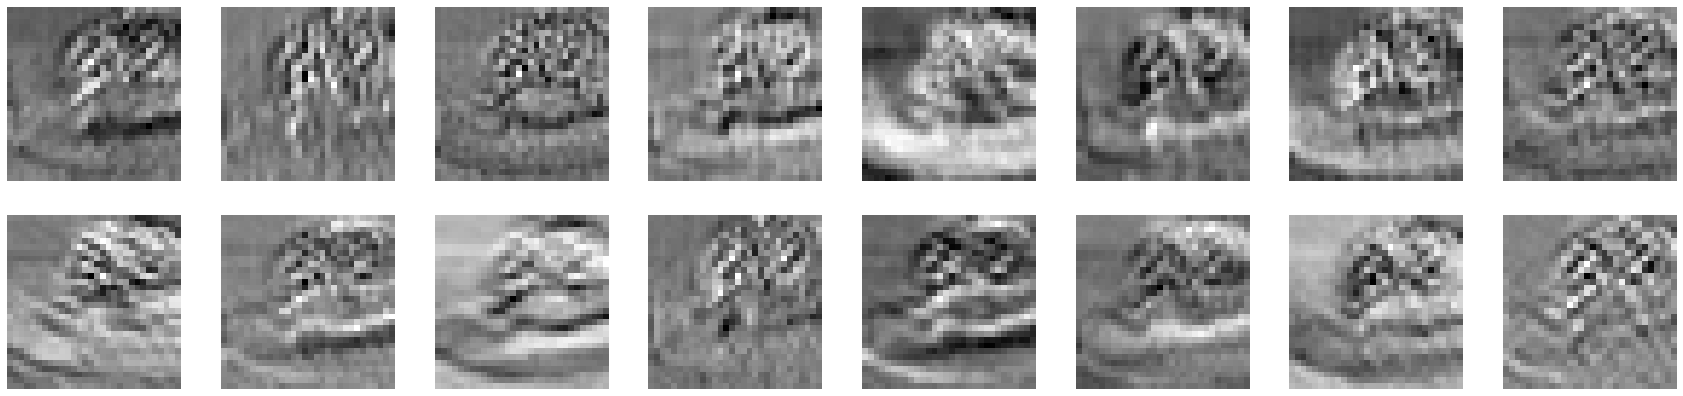

torch.Size([16, 28, 28])
Saving layer 1 feature maps...


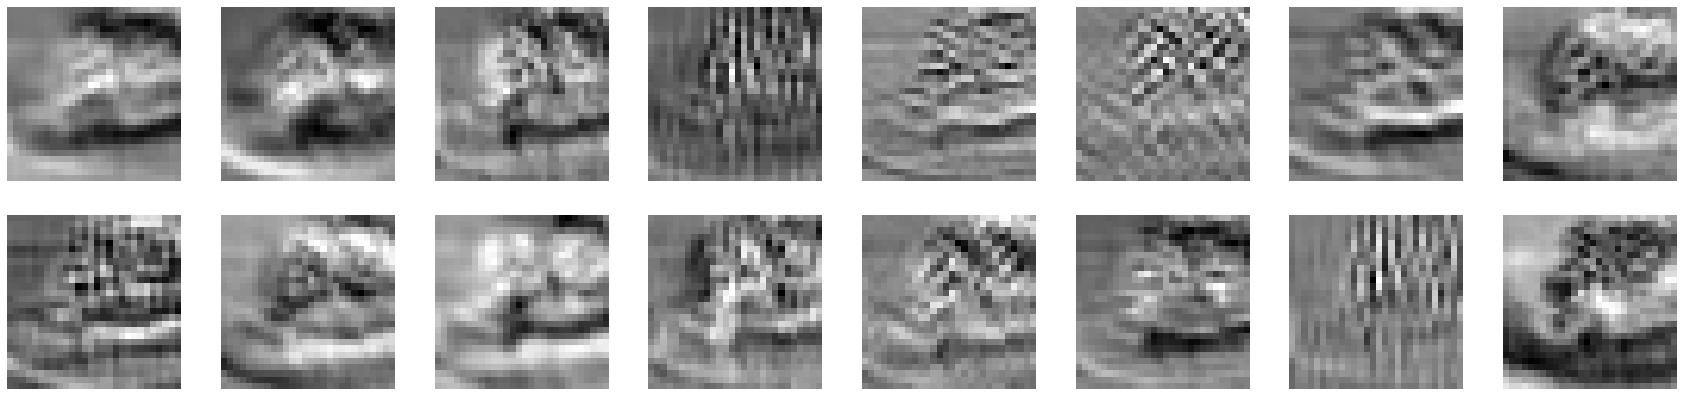

torch.Size([32, 26, 26])
Saving layer 2 feature maps...


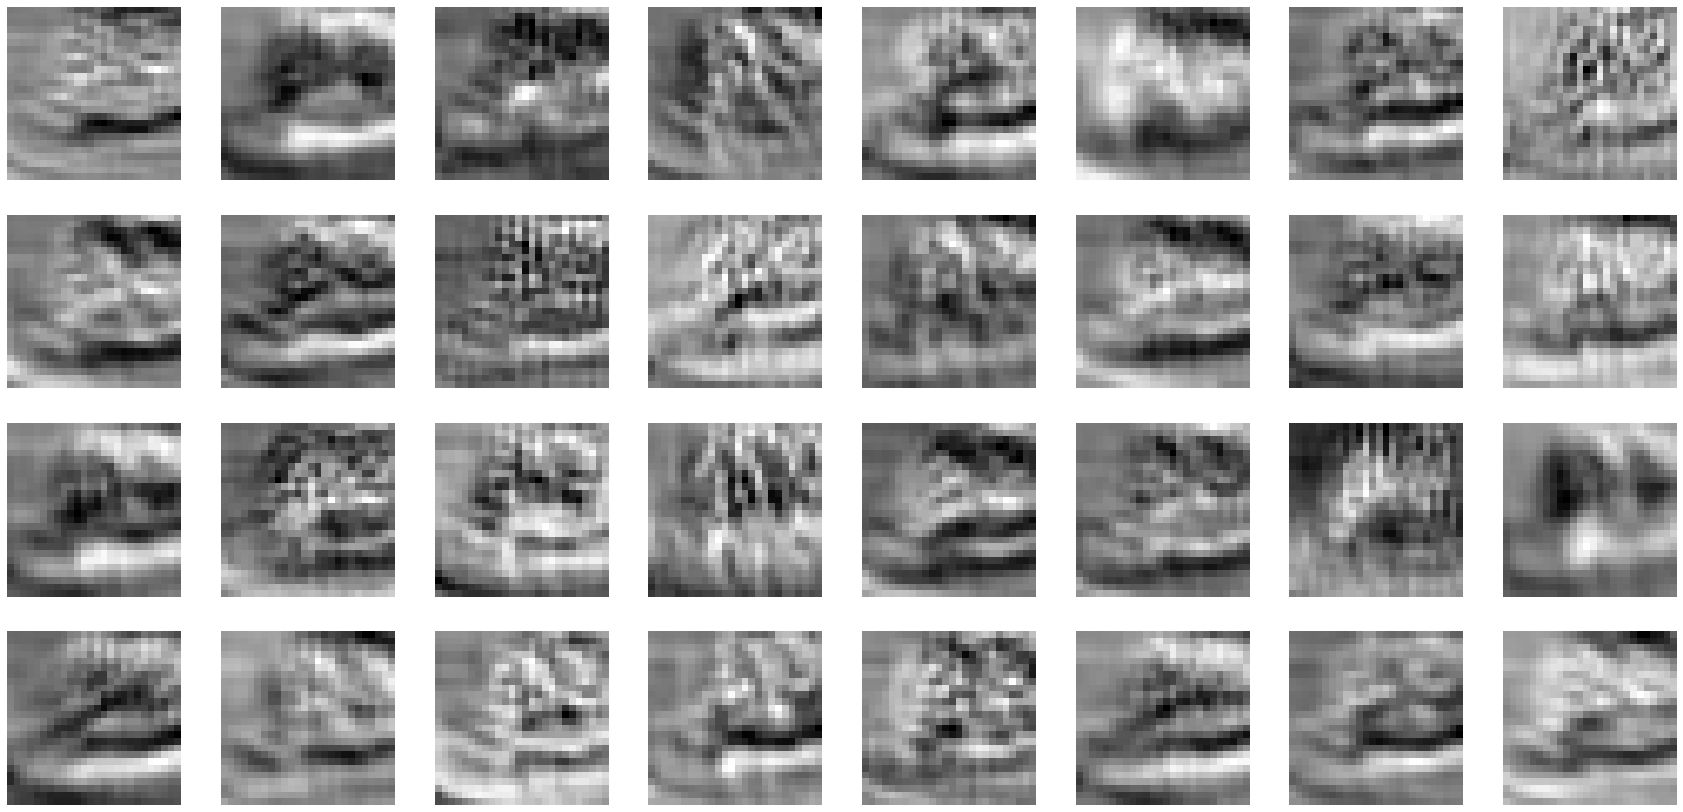

torch.Size([32, 24, 24])
Saving layer 3 feature maps...


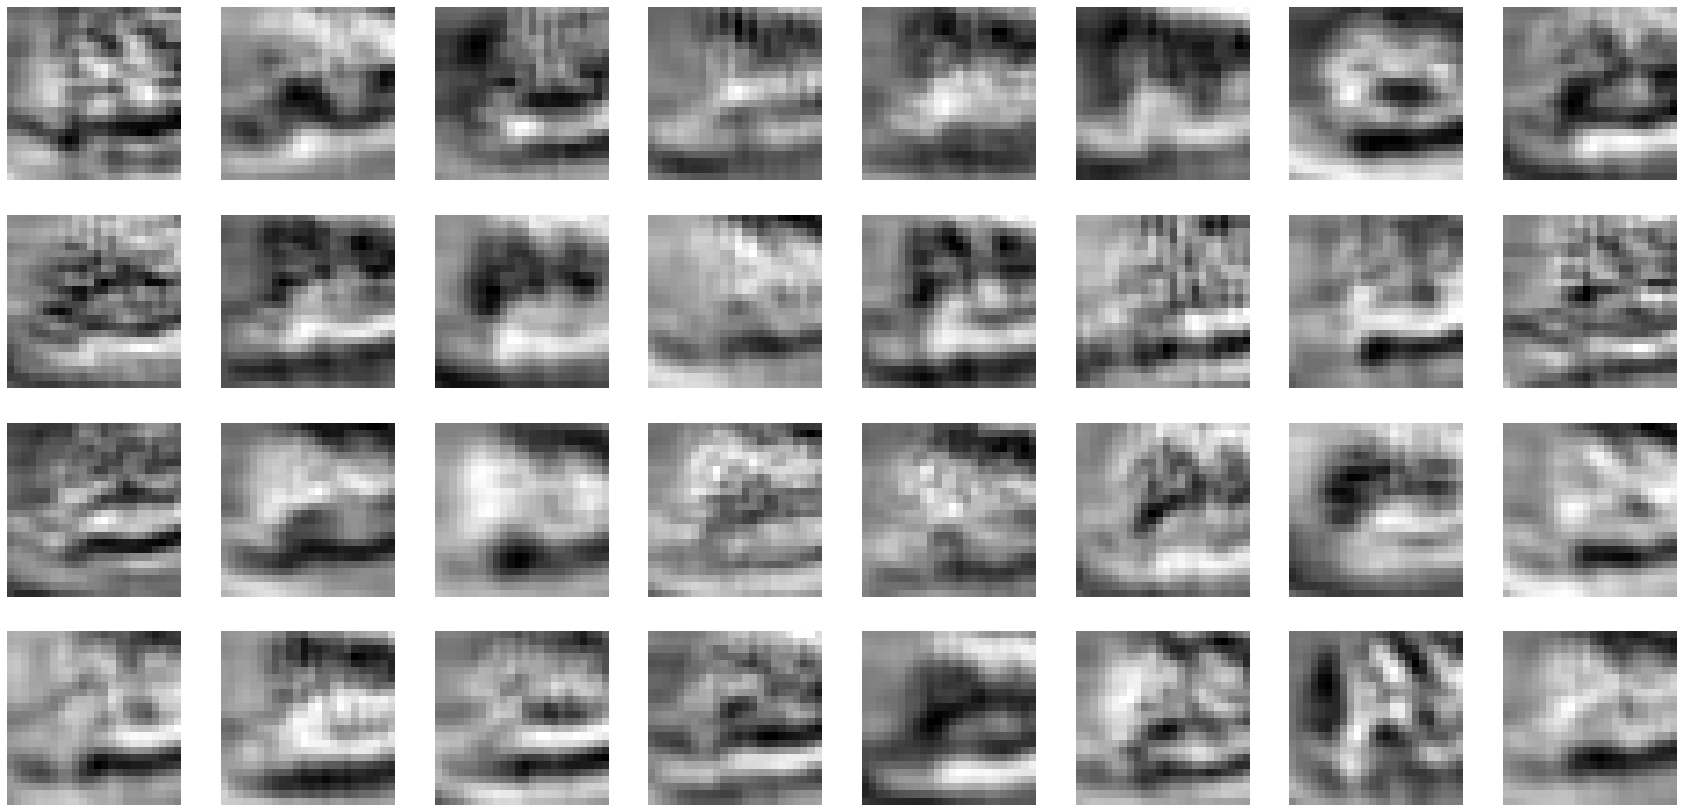

torch.Size([32, 22, 22])
Saving layer 4 feature maps...


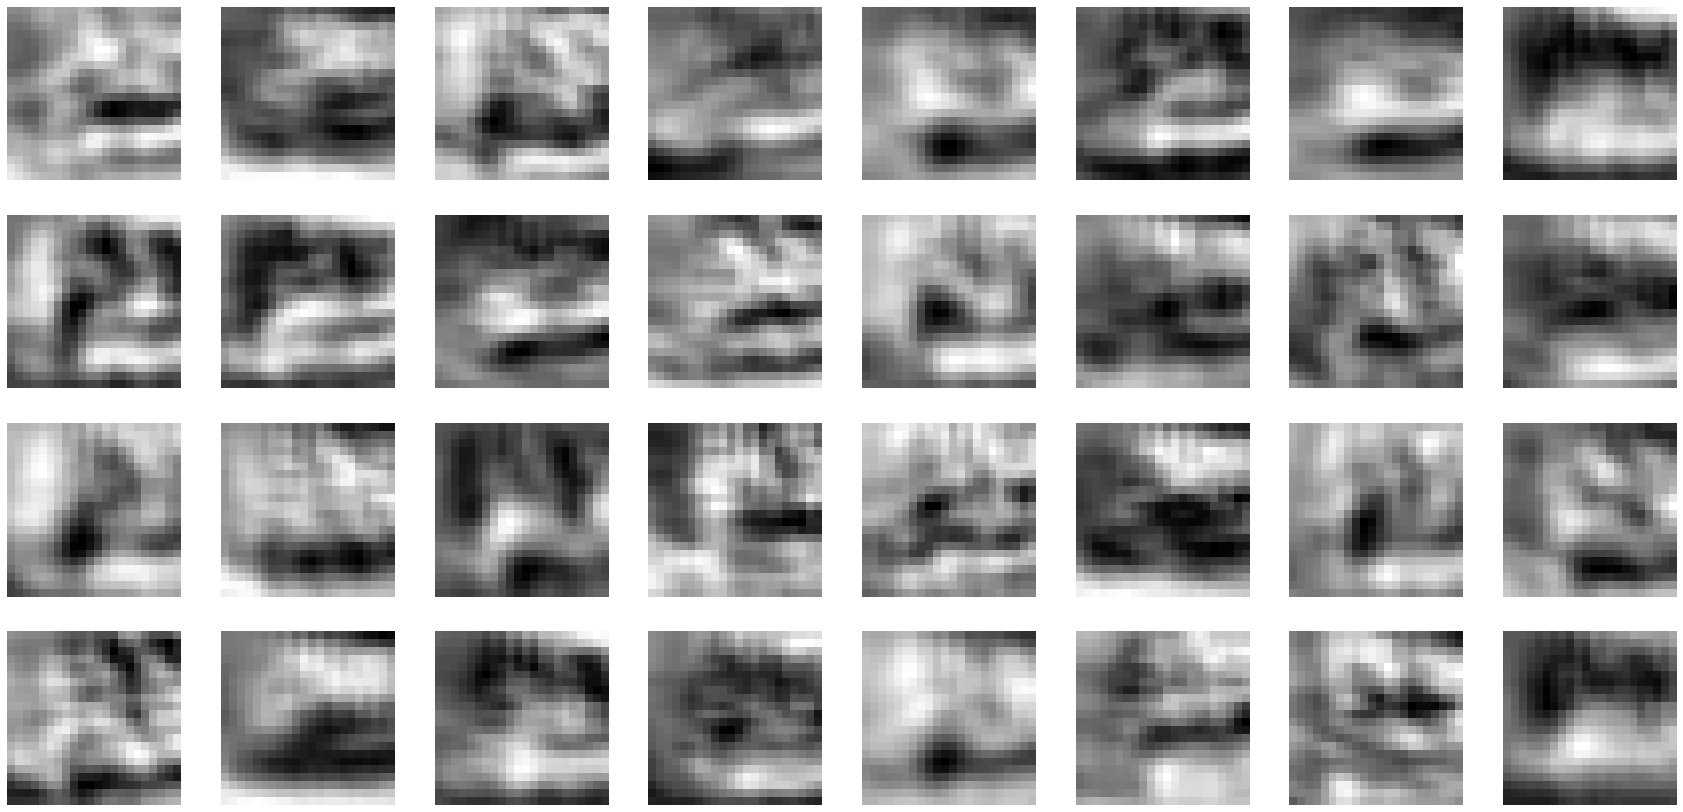

torch.Size([64, 20, 20])
Saving layer 5 feature maps...


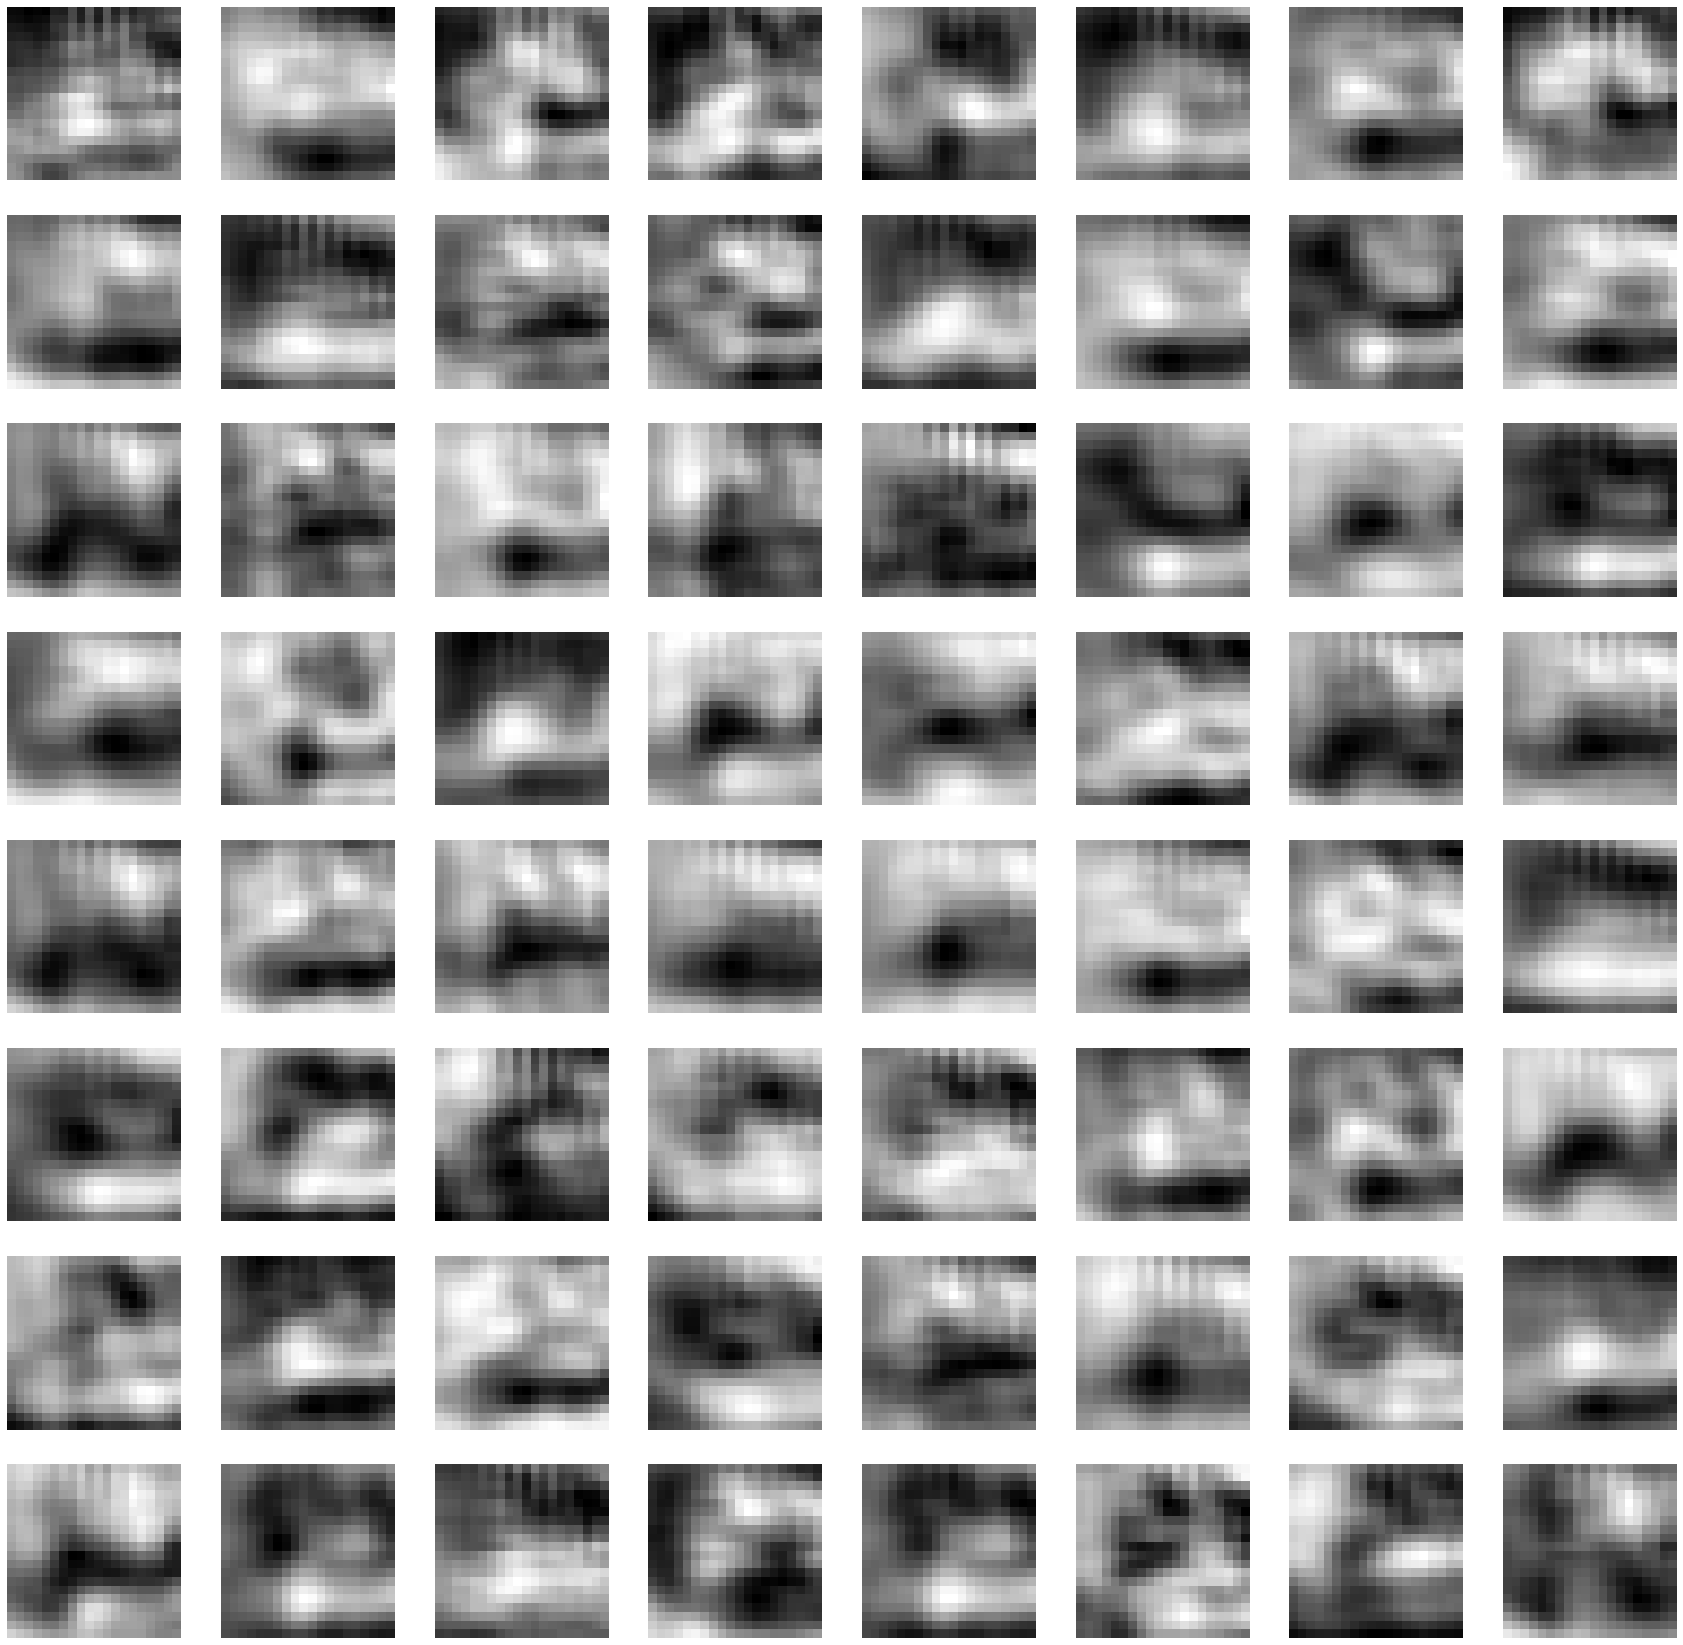

In [95]:
# All layers feature maps 
# visualize 64 features from each layer 
# (although there are more feature maps in the upper layers)
for num_layer in range(len(outputs)):
    plt.figure(figsize=(30, 30))
    layer_viz = outputs[num_layer][0, :, :, :]
    layer_viz = layer_viz.data
    print(layer_viz.size())
    for i, filter in enumerate(layer_viz):
        if i == 64: # we will visualize only 8x8 blocks from each layer
            break
        plt.subplot(8, 8, i + 1)
        plt.imshow(filter.cpu(), cmap='gray')
        plt.axis("off")
    print(f"Saving layer {num_layer} feature maps...")
    # plt.savefig(f"../outputs/layer_{num_layer}.png")
    plt.show()
    plt.close()